# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Masoumeh Bakhtiariziabari"
NAME2 = "Changxin Miao"
NAME3 = "Abel Ságodi"
EMAIL = "mbakhtiariz@gmail.com"
EMAIL2 = "mcx2576@gmail.com"
EMAIL3 = "abel.sagodi@gmail.com"

---

# Lab 2: Classification

### Machine Learning 1, September 2017

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

Populating the interactive namespace from numpy and matplotlib


# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [3]:
from sklearn.datasets import fetch_mldata
# Fetch the data
mnist = fetch_mldata('MNIST original')
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

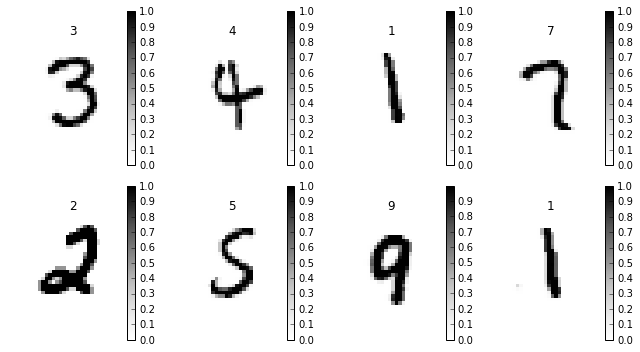

In [4]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} = 1-\frac{1}{Z}\exp \log q_j
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= -\frac{1}{Z}q_j
\end{align}
YOUR ANSWER HERE

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

YOUR ANSWER HERE
$$
\mathbf{\delta}_j^q \frac{\partial \log q_j}{\partial W_{ij}} 
= \mathbf{\delta}_j^qx_i
$$

### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [87]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b

def log_likelihood(x, w, b):
    logq = x.dot(w)+b    
    Z = np.sum(np.exp(logq))
    za = np.max(logq)
    logZ = za + np.log(np.sum(np.exp(logq - za)))
    logp = logq - logZ 
    #print("index of max log likelihood:",np.argmax(np.array(logp[0])))
    
    return logp, logq, Z

def logreg_gradient(x, t, w, b):       
    logp, logq, Z = log_likelihood(x, w, b)
    dL_q=np.zeros((10,))
    dL_dw=np.zeros((784, 10))
    dL_db=np.zeros((10,))

    for j in range(10):
        if j==t:
            dL_q[j]=1-1/Z*np.power(e,logq[:,j])
        else:
            dL_q[j]=-1/Z*np.power(e,logq[:,j])
        dL_dw[:,j]=dL_q[j]*x
        dL_db[j]=dL_q[j]
    #print(dL_dw)
    #print(logp.shape)
    #print(t)
    #print(logp[:,t])
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [88]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
('Likelihood:\t', array(-2.2959726720744777))
('\nGrad_W_ij\t', (784, 10), 'matrix')
('Grad_W_ij[0,152:158]=\t', array([-0.04518971, -0.06758809, -0.07819784, -0.09077238, -0.07584012,
       -0.06365855]))
('\nGrad_B_i shape\t', (10,), 'vector')
('Grad_B_i=\t', array([-0.10020327, -0.09977827, -0.1003198 ,  0.89933657, -0.10037941,
       -0.10072863, -0.09982729, -0.09928672, -0.09949324, -0.09931994]))
i in {0,...,9}; j in M


In [89]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide can compute the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



('Finite difference error grad_w:', 6.420766263386158e-07)
('Finite difference error grad_b:', 5.2351174951052616e-08)



### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1E-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [90]:
def sgd_iter(x_train, t_train, W, b):
    
    arr = np.arange(len(x_train)) 
    np.random.shuffle(arr)                         
    #logpt_for_one_x = np.zeros((10, len(t_train)))
    #logp_temp = [] * len(x_train)   
    wml = W.copy()
    bml = b.copy()
    for i in arr:
        _, grad_w, grad_b = logreg_gradient(x_train[i:i+1], t_train[i], wml, bml)
        wml += (1e-6)*grad_w
        bml += (1e-6)*grad_b
    
    logp_train = 0
    for i in range(len(x_train)):
        logp_perdata, _, _ = log_likelihood(x_train[i:i+1], W, b)
        logp_train += logp_perdata[:, t_train[i]]
        #print(logp_train)
    logp_train = logp_train/len(x_train)
    
    #print(logp_train, W, b)
    return logp_train, wml, bml

In [91]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)


## 1.2. Train

### 1.2.1 Train (10 points)
Perform 10 SGD iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


In [93]:
import matplotlib.pyplot as plt
def test_sgd(x_train, t_train, w, b):
    lpt = []
    lpv = []
    for i in range(10):  
        print("Epoch",i)
        logp_train, w, b = sgd_iter(x_train, t_train, w, b)
        print("train:",logp_train)
        lpt.append(logp_train)
        #--------------------------------------------------------------------------
        logp_valid = 0
        for i in range(len(x_valid)):
            logp_perdata, _, _ = log_likelihood(x_valid[i:i+1], w, b)
            logp_valid += logp_perdata[:, t_valid[i]]
        logp_valid = logp_valid/len(x_valid)
        lpv.append(logp_valid)
        print("valid:",logp_valid)
    print(np.array(lpt).shape)
    print(np.array(lpv).shape)
    return w, b, lpt, lpv

np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w, b, lpt, lpv = test_sgd(x_train, t_train, w, b)

('Epoch', 0)
('train:', array([-2.30258509]))
('valid:', array([-2.24930302]))
('Epoch', 1)
('train:', array([-2.24947421]))
('valid:', array([-2.19835342]))
('Epoch', 2)
('train:', array([-2.19868652]))
('valid:', array([-2.14950231]))
('Epoch', 3)
('train:', array([-2.14998375]))
('valid:', array([-2.1025607]))
('Epoch', 4)
('train:', array([-2.10317827]))
('valid:', array([-2.05741231]))
('Epoch', 5)
('train:', array([-2.05815078]))
('valid:', array([-2.01396043]))
('Epoch', 6)
('train:', array([-2.01480439]))
('valid:', array([-1.97212217]))
('Epoch', 7)
('train:', array([-1.97305889]))
('valid:', array([-1.93183421]))
('Epoch', 8)
('train:', array([-1.93284982]))
('valid:', array([-1.89303562]))
('Epoch', 9)
('train:', array([-1.89411697]))
('valid:', array([-1.85566957]))
(10, 1)
(10, 1)


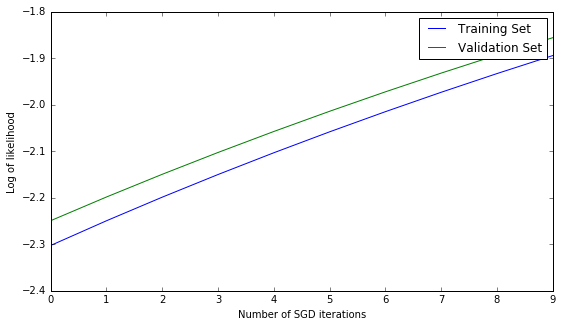

In [94]:
x = [i for i in range(10)]
plt.figure(1)
plt.plot(x,lpt, label='Training Set')
plt.plot(x,lpv, label='Validation Set')
plt.legend()
plt.xlabel("Number of SGD iterations")
plt.ylabel("Log of likelihood")
plt.show()
plt.close()

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


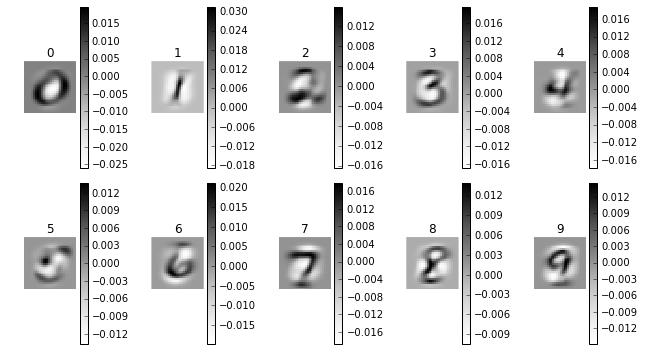

In [95]:
def visualize_weights(w):
    w_reshaped = np.reshape(np.transpose(w), (10,28,28))
    plot_digits(data=w_reshaped, num_cols=5, targets=np.arange(10))
visualize_weights(w)

Minimum loss is achieved when we get maximal response for the correct class output (and minimal for the rest.) Since the weights are multiplied by the corresponding input locations, the response would be maximized when the input image and the corresponding weights values for the correct class match well. It should be noted that areas that can best discriminate between similar classes would get higher weights; For example top-right part of weights associated with 6 is getting extra positive values to prevent a high response for samples from class 8.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

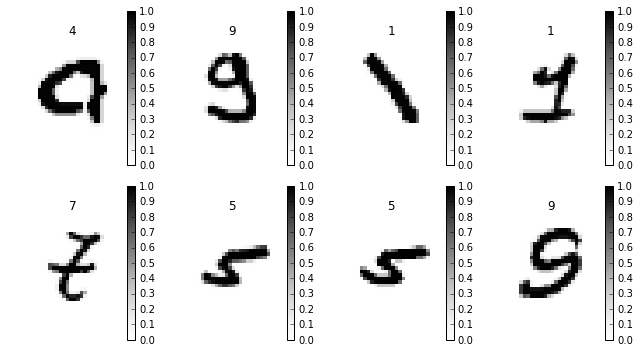

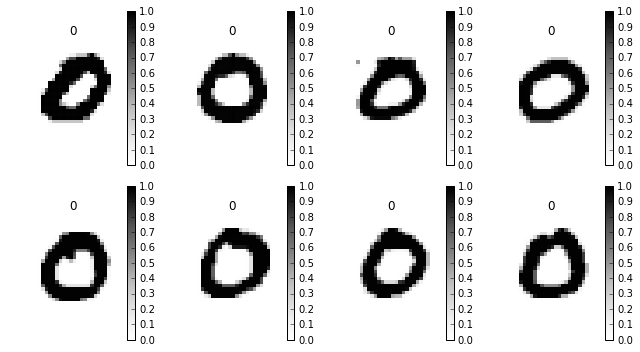

In [96]:
logp_valid = []
for i in range(len(x_valid)):
    logp_perdata, _, _ = log_likelihood(x_valid[i:i+1], w, b)
    logp_valid.append(logp_perdata[:, t_valid[i]])

sorted_index = np.argsort(np.array(logp_valid).squeeze())

min_prob_x = [x_valid[sorted_index[i]] for i in range(8)]
min_prob_t = [t_valid[sorted_index[i]] for i in range(8)]
plot_digits(np.array(min_prob_x), num_cols=4, targets=min_prob_t)

max_prob_x = [x_valid[sorted_index[i]] for i in range(len(sorted_index)-8,len(sorted_index))]
max_prob_t = [t_valid[sorted_index[i]] for i in range(len(sorted_index)-8,len(sorted_index))]

plot_digits(np.array(max_prob_x), num_cols=4, targets=max_prob_t)


# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

In the case of $\nabla_b\mathcal{L}^{(n)}$ we have the same deriatives for the elements of the gradient which we can split it, namely, $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} = \delta^q_j$ and $\frac{\partial \log q_j}{\partial b_j} = 1$. 
We had that 
\begin{align}
 \delta_j^q = 
  \begin{cases}
    1 - \frac{q_j}{Z}, & j = t^{(n)} \\
    - \frac{q_j}{Z}, & j \neq t^{(n)}
  \end{cases}
\end{align}


For $\nabla_{w_j}\mathcal{L}^{(n)}$ we have for the elements of the gradient 
$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} 
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$
while in this case 
$
\frac{\partial \log q_j}{\partial W_{ij}} = h_i.
$

In order to compute $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$
we split the parital derivative as
$\frac{\partial \mathcal{L}^{(n)}}{\partial \bh_i} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_i} = \delta_j^q \cdot W_{ij}$. Then $\delta^h$ = $(\delta_j^q W_{ij})_i$.

$\frac{\partial \mathcal{L}^{(n)}}{\partial V_{ij}}  = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_j}\frac{\partial \bh_j}{\partial V_{ij}} = \mathbf{\delta}_j^q w_{jj}x_i\sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j)) = \mathbf{\delta}_j^h x_i\sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j)) $


$\frac{\partial \mathcal{L}^{(n)}}{\partial a_{j}}  = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}\frac{\partial \log q_j}{\partial \bh_j}\frac{\partial \bh_j}{\partial a_{j}} = \mathbf{\delta}_j^q w_{jj}\sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j)) = \mathbf{\delta}_j^h \sigma(\bv_j^T \bx + a_j)(1-\sigma(\bv_j^T \bx + a_j))$


## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

The log likelihood was given by
$$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z.$$

The Maximum A Posteriori for the weights $\bW$ will be found be solving/optimizing (with SGD)
$$\log q_j - \log Z - \log p(\bW)$$
where $p(\bW) = \mathcal{N}(\bW\;|\; \mu_1, \sigma_1)$
and for the weights $\bV$ with
$$\log q_j - \log Z - \log p(\bV)$$
where $p(\bV) = \mathcal{N}(\bV\;|\; \mu_2, \sigma_2)$
with some parameters $\mu_i, \sigma_i$ for $i=1,2$.

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Plot (in one graph) the conditional log-probability of the trainingset and validation set after each two iterations, as well as the weights.

- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [97]:
# Write all helper functions here
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit
def hactivation(x, v, a):
    h = expit(np.dot(x,v) + a)
    return h

def calc_likelihood(x, t, w, b, v, a):
    # Computes logp, logq, Z
    h =  expit(np.dot(x,v) + a)
    logq = np.dot(h, w) + b
    
    #calculate logz with sum-exp trick
    Z = np.sum(np.exp(logq))
    za = np.max(logq)
    logZ = za + np.log(np.sum(np.exp(logq - za)))
    logp = logq - logZ - prior_w / 2 * np.sum(w * w) - prior_v / 2 * np.sum(v * v)

    return logp, logq, Z, h


def mlp_gradient(x, t, w, b, v, a):
    logp, logq, Z, h = calc_likelihood(x, t, w, b, v, a)

    deltaq = -np.exp(logq) / Z  
    deltaq[:,t] += 1         

    #Calculate gradients
    dL_dw = (deltaq * h.T).T - prior_w * w.T
    dL_db = deltaq
    
    deltah = np.dot(deltaq, w.T)
    dL_dh = deltah
    dL_da = deltah * h * (1-h)
    dL_dv = (dL_da * x.T).T - prior_v * v.T
    return logp[:,t].squeeze(), dL_dw.T, dL_db.squeeze(), dL_dv.T, dL_da.squeeze()

def sgd_iter2(x_train, t_train, w, b, v, a):
    logp_train = np.zeros((len(t_train),))
    
    shuff_train = np.arange(len(t_train))
    np.random.shuffle(shuff_train)
    for i in shuff_train:
        logp_train[i], grad_w, grad_b, grad_v, grad_a = mlp_gradient(x_train[i:i+1],
                                                                                t_train[i:i+1], w, b, v, a)
        w = w + learning_rate*grad_w
        b = b + learning_rate*grad_b
        v = v + learning_rate*grad_v
        a = a + learning_rate*grad_a
    return logp_train, w, b, v, a


def test_sgd(x_train, t_train, x_valid, t_valid, w, b, v, a, epochs, learning_rate):
    logp_array = np.array([])   
    logp_train_average = np.array([])   
    logp_valid_average = np.array([])
    for i in range(epochs):
        print("Epoch:" + str(i))
        logp_train, w, b, v, a = sgd_iter2(x_train, t_train, w, b, v, a)
        if (i%2 == 0):
            total_logp_va = 0
            logp_train_average = np.append(logp_train_average,np.average(logp_train))
            for j, x in enumerate(x_valid):
                logp_va, _, _, _ = calc_likelihood(x_valid[j], t_valid[j], w, b, v, a)
                total_logp_va += logp_va[t_valid[j]].squeeze()
            logp_valid_average = np.append(logp_valid_average,total_logp_va/len(x_valid))
            print(np.average(logp_train), total_logp_va/len(x_valid))
    return logp_train_average, logp_valid_average, w, b, v, a

def predict_MLP(w, b, v, a, x):
    #Classify handwritten digit with highest probability
    h = expit(np.dot(x,v) + a)
    logq = np.dot(h, w) + b
    return np.argmax(logq, axis=1)

In [98]:
np.random.seed(123)
hnum = 20
w = np.random.normal(size=(hnum,10), scale=0.001)
v = np.random.normal(size=(28*28,hnum), scale=0.001)
b = np.zeros((10,))
a = np.zeros((hnum,))
prior_w, prior_v = (0,0)
global prior_w
global prior_v

epochs = 10
learning_rate = 10**(-1)
start = time.time()
logp_train_average, logp_valid_average, w,b,v,a = test_sgd(x_train, t_train, x_valid, t_valid, 
                                                               w, b, v, a, epochs, learning_rate)
end = time.time()
print("Duration:" + str(round((end-start)/60,2)) + "minutes")

Epoch:0
(-0.40576095184868138, -0.29057180503192476)
Epoch:1
Epoch:2
(-0.21839085870683103, -0.23128596875330204)
Epoch:3
Epoch:4
(-0.1873207509303241, -0.22792691988022051)
Epoch:5
Epoch:6
(-0.16851425799115291, -0.20403040924099053)
Epoch:7
Epoch:8
(-0.15742104536758933, -0.21643764984741401)
Epoch:9
Duration:6.43minutes


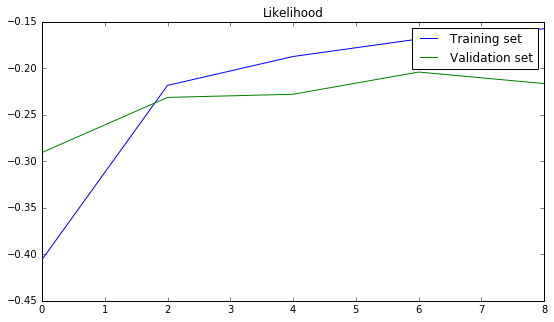

In [99]:
plt.plot(range(0, epochs, 2), logp_train_average,label='Training set')
plt.plot(range(0, epochs, 2), logp_valid_average,label='Validation set')
plt.title("Likelihood")
plt.legend()
plt.show()

Note: learning rate is too high for 10 epochs

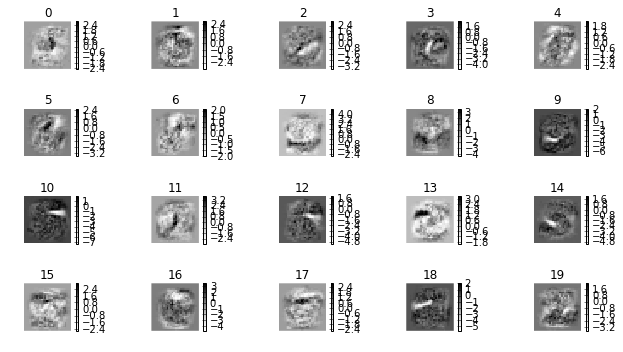

In [105]:
def visualize_weights2(w, hnums):
    w_reshaped = np.reshape(np.transpose(w), (hnums,28,28))
    plot_digits(data=w_reshaped, num_cols=5, targets=np.arange(hnums))
visualize_weights2(v, hnum)

### 2.3.1. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

The output of the hidden layer is dependent on the sigmoid function and are not directly related to the digit labels in the output layer. The MLP algorithm has more parameters $784*L + L*10$ with $L$ the number of hidden units and can hence learn better. Besides, because the MLP structure allows an intermediate layer between input and output, it allows to subtract higher order correlations between the input elements.

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.

In [83]:
np.random.seed(123)
hnum = 200
# w = np.random.normal(size=(hnum,10), scale=0.001)
# v = np.random.normal(size=(28*28,hnum), scale=0.001)
# b = np.zeros((10,))
# a = np.zeros((hnum,))

epochs = 5
learning_rate = 10**(-2)
logp_train_average, logp_valid_average, w,b,v,a = test_sgd(x_train, t_train, x_valid, t_valid, 
                                                               w, b, v, a, epochs, learning_rate)

predict_test = predict_MLP(w, b, v, a, x_test)
correctness = (t_test == predict_test)
accuracy = np.average(correctness) 
print(accuracy)

Epoch:0
(-0.047433101658659327, -0.072299676692488241)
Epoch:1
Epoch:2
(-0.030953534535326267, -0.066804713214333622)
Epoch:3
Epoch:4
(-0.025185869228465999, -0.06548936027422643)
0.9758


Idea for learning fast: start with high learning rate and decrease over time. So start with 5 iterations with learning rate $10^{-1}$. Then do 5 with $10^{-2}$ and 10 with $10^{-4}$. This will result in less than 2.5% errors on the validation set.

In [84]:
assert predict_test.shape == t_test.shape
n_errors = np.sum(predict_test != t_test)
print('Test errors: %d' % n_errors)

Test errors: 242
